In [26]:
import csv
import random
import os
from sklearn.preprocessing import RobustScaler, MinMaxScaler, normalize
import scipy
from scipy.signal import savgol_filter, butter, lfilter, ShortTimeFFT
from scipy.signal.windows import gaussian, triang, hamming

import librosa

import matplotlib.pyplot as plt
import numpy as np

In [27]:
filename = os.path.join('.', 'AudioMNIST', 'data', '01', str(random.randint(0, 9)) + '_01_' + '0' + '.wav')
print(filename)

.\AudioMNIST\data\01\2_01_0.wav


теперь попробуем удалить один канал и прослушать его

In [28]:
req_len = 0.6

data, rate = librosa.load(filename, sr=None, mono=True)

if(len(data) > 30_000):
  data = data[(len(data) - 30_000) // 2:30_000 + (len(data) - 30_000) // 2]
elif (len(data) < 30_000):
  data = np.pad(data, ((30_000 - len(data)) // 2))
data_filtered = data

print(data)
print(len(data)/rate, rate, len(data))


[0. 0. 0. ... 0. 0. 0.]
0.6249791666666666 48000 29999


In [29]:
t = np.arange (0, len(data)/rate, 1/rate)
print(t, len(t)/rate)

[0.00000000e+00 2.08333333e-05 4.16666667e-05 ... 6.24916667e-01
 6.24937500e-01 6.24958333e-01] 0.6249791666666666


c:\Users\Иван\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:7720: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


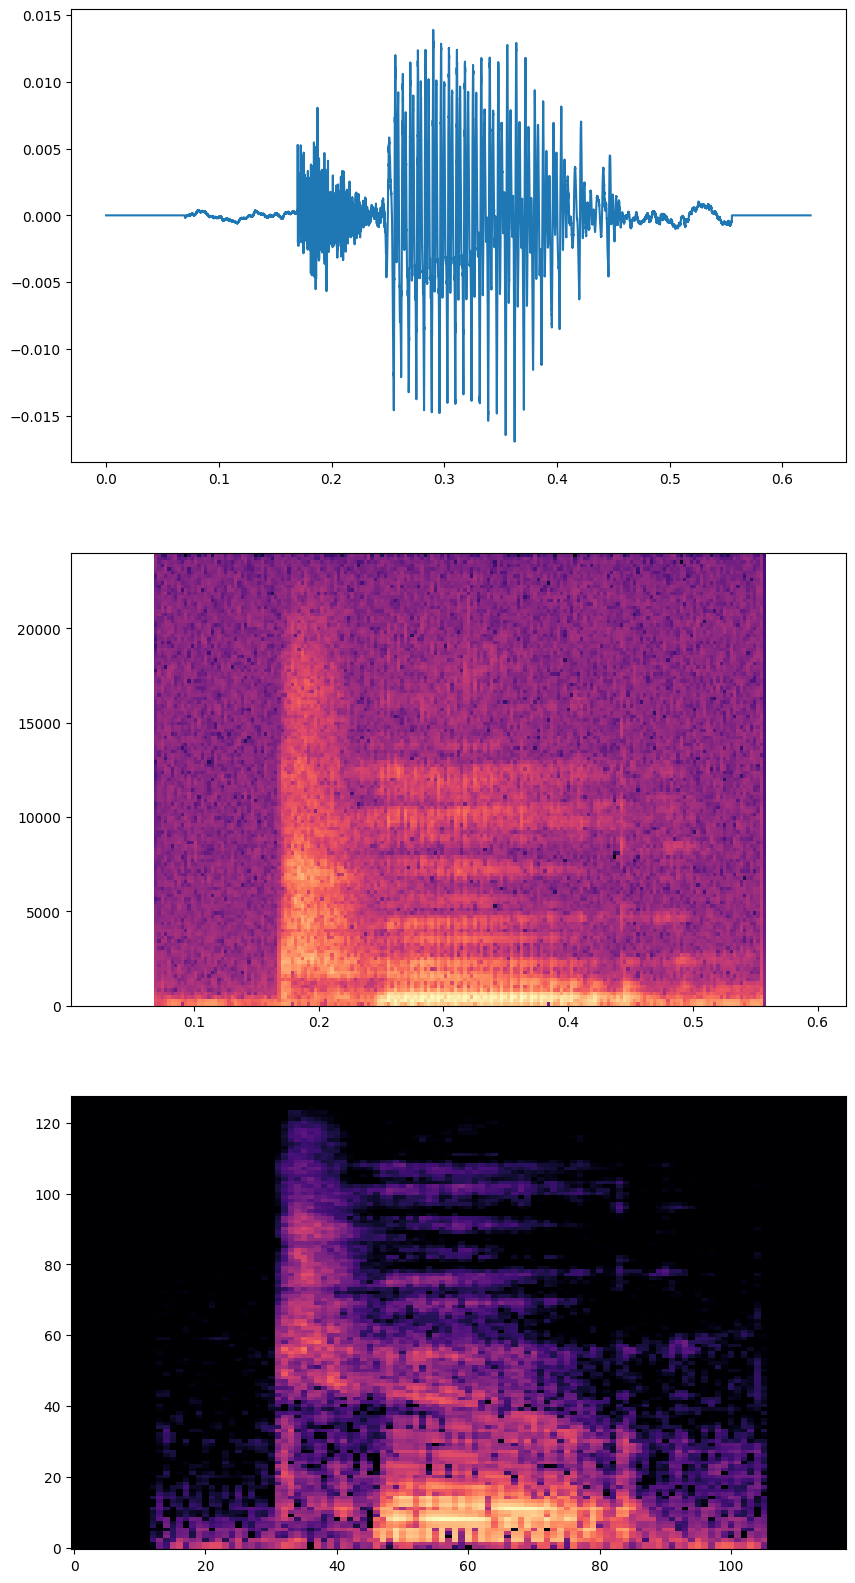

.\AudioMNIST\data\01\2_01_0.wav


In [30]:
fig, (ax0, ax4, ax5) = plt.subplots(nrows=3, sharex=False)

ax0.plot(t, data_filtered)

ax4.specgram(data_filtered, Fs=rate, cmap='magma')

Pxx = librosa.stft(data, dtype=np.float32, n_fft=1024)
Pxx, _ = librosa.magphase(Pxx)
Pxx = librosa.feature.melspectrogram(S=Pxx, sr=rate, n_fft=1024)
Pxx = librosa.amplitude_to_db(Pxx, ref=np.min)
im1 = ax5.imshow(Pxx, origin='lower', cmap='magma', aspect='auto')

ax5.axis()
fig.set_figwidth(10)
fig.set_figheight(20)
# ax3.axis(ymin=0, ymax=750)
# ax4.axis(ymin=0, ymax=750)
# ax5.axis(ymin=0, ymax=750)
plt.show()
print(filename)

In [31]:
print(Pxx.max())
print(Pxx.shape)

74.134895
(128, 118)


(128, 118)


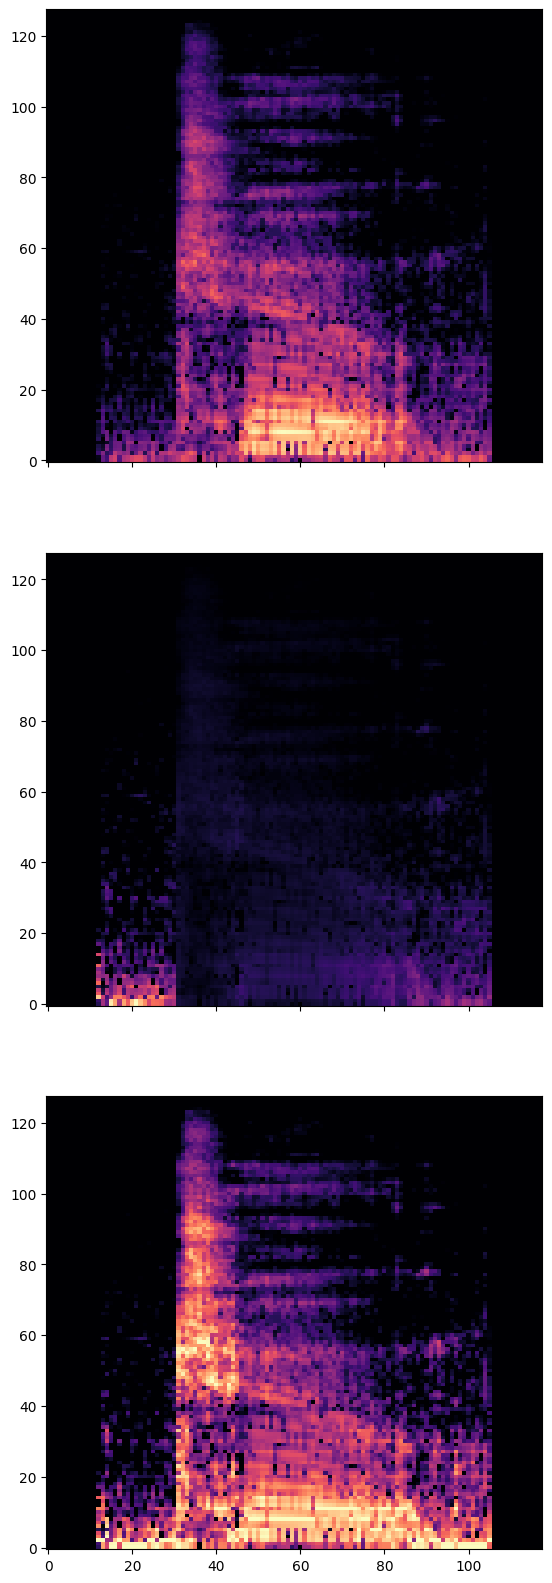

In [32]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True)

scalerR = RobustScaler()

# Pxx, freqs, bins, im = ax0.specgram(data_filtered, Fs=rate, scale='dB', pad_to=255, mode='psd', scale_by_freq=True, detrend='mean')
map1 = ax0.imshow(Pxx, origin='lower', aspect='auto', cmap='magma')

Pxx2 = normalize(Pxx, axis=0, norm='l1')
map2 = ax1.imshow(Pxx2, origin='lower', aspect='auto', cmap='magma')

scaler = MinMaxScaler()

Pxx3 = scaler.fit_transform(Pxx)
map3 = ax2.imshow(Pxx3, origin='lower', aspect='auto', cmap='magma')

# fig.set_figwidth(80)
# fig.set_figheight(20)
# ax0.axis(ymin=0, ymax=1)
# ax1.axis(ymin=0, ymax=1)
fig.set_figheight(20)
print(Pxx.shape)

plt.show()

In [33]:
Pxx = np.array(Pxx)
print(Pxx3, len(Pxx3)) # элемент массива - амплитуды частот
print(Pxx.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 128
(128, 118)


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

Теперь нужно создавать такую спектрограмму для любого файла и паковать ее в трехмерный массив:

In [35]:

class SinglePatientData:
  def __init__(self, name : str, out : int, subfolder : str):
    self.contents = name
    self.num = out
    self.subfolder = subfolder

  def getTensor(self, path): # returns 129x1249x5 torch tensor
    if (hasattr(self, 'specgrams')):
      return self.specgrams
    else:
      data, rate = librosa.load(os.path.join(path, self.subfolder, self.contents + '.wav'), sr=None, mono=True)

      if(len(data) > 30_000):
        data = data[(len(data) - 30_000) // 2:30_000 + (len(data) - 30_000) // 2]
      elif (len(data) < 30_000):
        data = np.pad(data, ((30_000 - len(data)) // 2))

      Pxx = librosa.stft(data, dtype=np.float32, n_fft=1024)
      Pxx, _ = librosa.magphase(Pxx)
      Pxx = librosa.feature.melspectrogram(S=Pxx, sr=rate, n_fft=1024)
      Pxx = librosa.amplitude_to_db(Pxx, ref=np.min)

      self.specgrams = torch.from_numpy(np.array([Pxx], dtype='float32'))
      return self.specgrams
    

In [36]:
def getstr(num):
  if(num < 10):
    return '0' + str(num)
  else:
    return str(num)

def createDataArray():
  retArray = []
  for m in range(1, 61):
    for i in range(10):
      for j in range(50):
        retArray.append(SinglePatientData(str(i) + '_' + getstr(m) +'_' + str(j), i, getstr(m)))
  return retArray

In [37]:
foldername = os.path.join('.', 'AudioMNIST', 'data')

In [38]:
dataArray = createDataArray()

print(dataArray[0].contents, dataArray[0].subfolder)

0_01_0 01


torch.Size([128, 118])
5_15_32


c:\Users\Иван\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:371: ComplexWarning: Casting complex values to real discards the imaginary part
  stft_matrix[..., :off_start] = fft.rfft(fft_window * y_frames_pre, axis=-2)
c:\Users\Иван\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:375: ComplexWarning: Casting complex values to real discards the imaginary part
  stft_matrix[..., -off_end:] = fft.rfft(fft_window * y_frames_post, axis=-2)
c:\Users\Иван\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:387: ComplexWarning: Casting complex values to real discards the imaginary part
  stft_matrix[..., bl_s + off_start : bl_t + off_start] = fft.rfft(


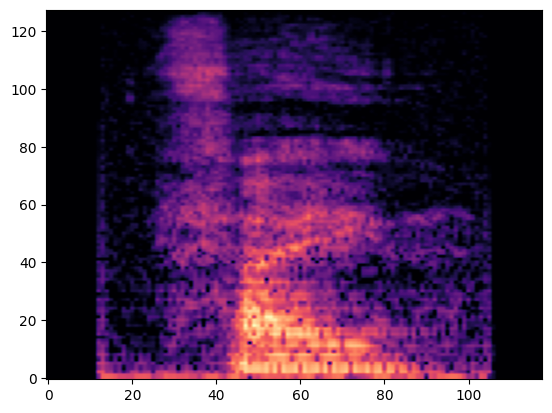

In [39]:
dataIterator = iter(dataArray)

fig, (ax0) = plt.subplots(nrows=1, sharex=True)
rnd = random.choice(dataArray)
print(rnd.getTensor(foldername)[0].shape)
map3 = ax0.imshow(rnd.getTensor(foldername)[0], origin='lower', aspect='auto', cmap='magma')
print(rnd.contents)
plt.show()

Теперь можно приступать к созданию первой модели

In [40]:
print(torch.__version__)

2.6.0+cpu


In [41]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()

        conv_layers = []

        self.conv1 = nn.Conv2d(1, 8, kernel_size=(2,2), stride=(1,1), padding=(2,2))
        self.relu1 = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1]

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(2,2), stride=(1,1), padding=(2,2))
        self.relu2 = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2]

        # self.conv3 = nn.Conv2d(16, 32, kernel_size=(2,2), stride=(1,1), padding=(1,1))
        # self.relu3 = nn.ReLU()
        # torch.nn.init.kaiming_normal_(self.conv3.weight, a=0.1)
        # self.conv3.bias.data.zero_()
        # conv_layers += [self.conv3, self.relu3]

        # self.conv4 = nn.Conv2d(32, 64, kernel_size=(2,2), stride=(1,1), padding=(1,1))
        # self.relu4 = nn.ReLU()
        # torch.nn.init.kaiming_normal_(self.conv4.weight, a=0.1)
        # self.conv4.bias.data.zero_()
        # conv_layers += [self.conv4, self.relu4]

        self.conv5 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.relu5 = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv5.weight, a=0.1)
        self.conv5.bias.data.zero_()
        conv_layers += [self.conv5, self.relu5]

        self.conv6 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.relu6 = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv6.weight, a=0.1)
        self.conv6.bias.data.zero_()
        conv_layers += [self.conv6, self.relu6]

        self.conv7 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.relu7 = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv7.weight, a=0.1)
        self.conv7.bias.data.zero_()
        conv_layers += [self.conv7, self.relu7]

        self.conv8 = nn.Conv2d(128, 256, kernel_size=(5,5), stride=(4,4), padding=(1,1))
        self.relu8 = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv8.weight, a=0.1)
        self.conv8.bias.data.zero_()
        conv_layers += [self.conv8, self.relu8]

        self.ap = nn.AdaptiveAvgPool2d(output_size=1)

        self.lin1 = nn.Linear(in_features=256, out_features=128)
        self.dropout1 = nn.Dropout(p=0.2)
        self.lin2 = nn.Linear(in_features=128, out_features=10)
        self.lin3 = nn.Linear(in_features=10, out_features=1)
        self.lin = nn.Sequential(*[self.lin1, self.dropout1, self.lin2, self.lin3])

        self.conv = nn.Sequential(*conv_layers)

    def forward(self, x):
        x = self.conv(x)

        x = self.ap(x)
        x = x.view(x.shape[0])

        x = self.lin(x)
        return x

Тестовый прогон:

In [42]:
model = ConvModel()
Pxx = next(dataIterator).getTensor(foldername)
print(Pxx.shape)
out = model(Pxx)
print(out.shape)

torch.Size([1, 128, 118])
torch.Size([1])


In [43]:
learning_rate = 0.001
num_epochs = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvModel()
model = model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [60]:
def get_acc(logit, target):
    ''' Check if answer is right for training round '''
    acc = 0
    for i in range(len(logit)):
        acc += (1 - abs(logit[i] - target[i])).item()
    return acc / len(target)

def get_acc_2(logit, target):
    ''' Check if answer is right for training round '''
    target_2 = target + 1
    logit_2 = logit + 1
    return ((target_2 - abs(logit_2 - target_2)) / target_2).item()

In [45]:
target = torch.empty(3, dtype=torch.long).random_(5)
print(target)
target = torch.randn(3, 5).softmax(dim=1)
print(target)

tensor([2, 2, 4])
tensor([[0.1931, 0.1698, 0.1746, 0.2996, 0.1629],
        [0.4276, 0.4823, 0.0040, 0.0461, 0.0399],
        [0.1158, 0.1799, 0.1041, 0.5606, 0.0396]])


Epoch: 0 | Loss: 1.5082 | Train Accuracy: 0.57
Epoch: 1 | Loss: 0.9557 | Train Accuracy: 0.66
Epoch: 2 | Loss: 0.8162 | Train Accuracy: 0.68
Epoch: 3 | Loss: 0.7437 | Train Accuracy: 0.68
Epoch: 4 | Loss: 0.6848 | Train Accuracy: 0.69
Epoch: 5 | Loss: 0.6513 | Train Accuracy: 0.70
Epoch: 6 | Loss: 0.6215 | Train Accuracy: 0.70
Epoch: 7 | Loss: 0.5942 | Train Accuracy: 0.70
Epoch: 8 | Loss: 0.5751 | Train Accuracy: 0.70
Epoch: 9 | Loss: 0.5594 | Train Accuracy: 0.70
Epoch: 10 | Loss: 0.5442 | Train Accuracy: 0.71
Epoch: 11 | Loss: 0.5284 | Train Accuracy: 0.71
Epoch: 12 | Loss: 0.5167 | Train Accuracy: 0.71
Epoch: 13 | Loss: 0.5004 | Train Accuracy: 0.71
Epoch: 14 | Loss: 0.4934 | Train Accuracy: 0.71
Epoch: 15 | Loss: 0.4866 | Train Accuracy: 0.71
Epoch: 16 | Loss: 0.4778 | Train Accuracy: 0.71
Epoch: 17 | Loss: 0.4660 | Train Accuracy: 0.71
Epoch: 18 | Loss: 0.4645 | Train Accuracy: 0.71
Epoch: 19 | Loss: 0.4576 | Train Accuracy: 0.71
Epoch: 20 | Loss: 0.4472 | Train Accuracy: 0.71
Ep

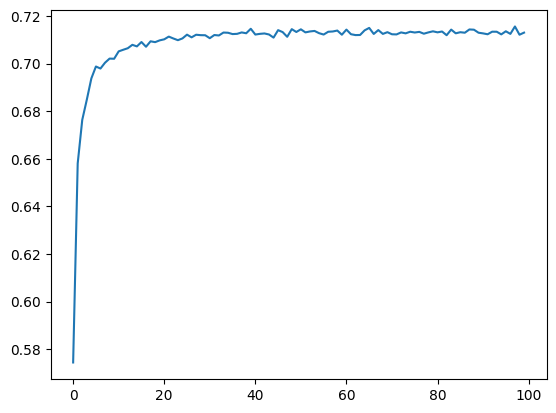

In [46]:
train_acc = 0
epoch = 0

fig, ax = plt.subplots()
accuracies = []
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    random.shuffle(dataArray)
    dataIterator = iter(dataArray)
    ## training step
    for i, patient in enumerate(dataIterator):
        labels = torch.tensor([patient.num], dtype=torch.float32)
        # labels = torch.tensor([0 if i != patient.num else 1 for i in range(10)], dtype=torch.float32)

        Pxx = patient.getTensor(foldername);

        ## forward + backprop + loss
        logits = model(Pxx)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()
        train_running_loss += loss.detach().item()
        train_acc += get_acc_2(logits, labels)
    model.eval()
    accuracies += [train_acc / i]
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))
    
ax.plot(accuracies)

plt.show()

In [62]:
train_running_loss, train_acc = 0., 0.
random.shuffle(dataArray)
dataIterator = iter(dataArray)
## training step
for i, patient in enumerate(dataIterator):
    labels = torch.tensor([patient.num], dtype=torch.float32)
    # labels = torch.tensor([0 if i != patient.num else 1 for i in range(10)], dtype=torch.float32)

    Pxx = patient.getTensor(foldername)

    ## forward + backprop + loss
    logits = model(Pxx)
    logits = torch.round(logits)
    loss = criterion(logits, labels)

    train_running_loss += loss.detach().item()
    train_acc += get_acc_2(logits, labels)
    print('target: %s, logits: %s, loss: %f, acc: %f' %(labels, logits, train_running_loss / (i + 1), train_acc / (i + 1)))

target: tensor([3.]), logits: tensor([3.], grad_fn=<RoundBackward0>), loss: 0.000000, acc: 1.000000
target: tensor([6.]), logits: tensor([6.], grad_fn=<RoundBackward0>), loss: 0.000000, acc: 1.000000
target: tensor([5.]), logits: tensor([5.], grad_fn=<RoundBackward0>), loss: 0.000000, acc: 1.000000
target: tensor([5.]), logits: tensor([5.], grad_fn=<RoundBackward0>), loss: 0.000000, acc: 1.000000
target: tensor([8.]), logits: tensor([8.], grad_fn=<RoundBackward0>), loss: 0.000000, acc: 1.000000
target: tensor([4.]), logits: tensor([4.], grad_fn=<RoundBackward0>), loss: 0.000000, acc: 1.000000
target: tensor([7.]), logits: tensor([7.], grad_fn=<RoundBackward0>), loss: 0.000000, acc: 1.000000
target: tensor([9.]), logits: tensor([9.], grad_fn=<RoundBackward0>), loss: 0.000000, acc: 1.000000
target: tensor([7.]), logits: tensor([7.], grad_fn=<RoundBackward0>), loss: 0.000000, acc: 1.000000
target: tensor([0.]), logits: tensor([1.], grad_fn=<RoundBackward0>), loss: 0.100000, acc: 0.900000


In [63]:
torch.save(model.state_dict(), os.path.join('.', 'models', 'audMNISTmodel', 'model.pt'))